# Student Dropout Analysis

**Annabel Lim, Owen Kwong, Yash Mali, Yui Mikuriya (Group 20)**

## 1. Introduction



Higher education institutions worldwide are attempting to effectively address diverse student learning styles and academic performances to enhance the learning experience. One interesting topic to consider is the dropout rate within higher education along with exploration of its root causes. There are many factors that could impact the likelihood of a student to drop out such as mental health issues, financial challenges, and weak academic backgrounds.

The goal of this project is to determine if students that dropped out had lower admission grades than the students who graduated. The Polytechnic Institute of Portalegre (IPP) has a dataset with student data from four schools in Portugal. It provides data on factors such as nationality, admission grades, and graduation status. To explore this goal, we have formulated the below research question:

**Research Question:** *Is there enough evidence to suggest that admission grades of students that dropped out are lower than those of students that graduated?*


## 2. Preliminary Results

We load libraries, set the seed and number of table rows to show.

In [4]:
# load libraries
library(cowplot)
library(datateachr)
library(digest)
library(infer)
library(repr)
library(taxyvr)
library(tidyverse)
library(dplyr)
library(datateachr)

# set seed
set.seed(2023);

# number rows for table 
options(repr.matrix.max.rows = 8)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::lag()       masks stats::lag()
✖ lubridate::stamp() masks cowplot::stamp()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


### Importing Data
We initially load our data to a temporarily dataframe.

In [6]:
# data url (zip file)
url <- "https://archive.ics.uci.edu/static/public/697/predict+students+dropout+and+academic+success.zip"

# unzip and load data
temp <- tempfile()
download.file(url,temp)
dropout_data <- read.csv2(unz(temp, "data.csv")) 
unlink(temp)

head(dropout_data) # shows that there are 4424 student entries

,Marital.status,Application.mode,Application.order,Course,Daytime.evening.attendance.,Previous.qualification,Previous.qualification..grade.,Nacionality,Mother.s.qualification,Father.s.qualification,⋯,Curricular.units.2nd.sem..credited.,Curricular.units.2nd.sem..enrolled.,Curricular.units.2nd.sem..evaluations.,Curricular.units.2nd.sem..approved.,Curricular.units.2nd.sem..grade.,Curricular.units.2nd.sem..without.evaluations.,Unemployment.rate,Inflation.rate,GDP,Target
,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>
1,1,17,5,171,1,1,122.0,1,19,12,⋯,0,0,0,0,0.0,0,10.8,1.4,1.74,Dropout
2,1,15,1,9254,1,1,160.0,1,1,3,⋯,0,6,6,6,13.666666666666666,0,13.9,-0.3,0.79,Graduate
3,1,1,5,9070,1,1,122.0,1,37,37,⋯,0,6,0,0,0.0,0,10.8,1.4,1.74,Dropout
4,1,17,2,9773,1,1,122.0,1,38,37,⋯,0,6,10,5,12.4,0,9.4,-0.8,-3.12,Graduate
5,2,39,1,8014,0,1,100.0,1,37,38,⋯,0,6,6,6,13.0,0,13.9,-0.3,0.79,Graduate
6,2,39,1,9991,0,19,133.1,1,37,37,⋯,0,5,17,5,11.5,5,16.2,0.3,-0.92,Graduate


Figure 1. Imported tibble of IPP student dropout data

### Variables Information
The description of columns are given by the data set information on the UCI Machine Learning Repository page.

**Admission.grade:** Students' admission grade is standardized (0-200).

**Target:** Student can be classified as three different types (dropout, enrolled, graduate).

### Cleaning the Data

Our primary focus is to transform the data into appropriate data types and filter out students who are currently enrolled. The dataset does not contain any missing values, allowing us to skip the consideration of NA values. Our specific area of interest within the dataset revolves around the admission grades of students. As a result, we will retain information related to the students' target status (Dropout or Graduated) and admission grades while discarding data pertaining to enrolled students.

In [17]:
#Clean the data
dropout_clean <- dropout_data %>%
  mutate(Target = as_factor(Target)) %>% #Convert the 'Target' column to a factor
  filter(Target != "Enrolled") %>%
  rename(Admission_Grade = Admission.grade)

#Select only the Target column 
dropout_pop <- dropout_clean %>%
  select(Target, Admission_Grade) %>%
  mutate(Admission_Grade = as.numeric(Admission_Grade))

head(dropout_pop)

,Target,Admission_Grade
,<fct>,<dbl>
1,Dropout,127.3
2,Graduate,142.5
3,Dropout,124.8
4,Graduate,119.6
5,Graduate,141.5
6,Graduate,114.8


To ensure that our sample is representative of our population of interest, we calculated the number of observation from each. It seems that with 1421 observation from students who dropped out and 2209 students who graduated, this dataset is in fact suited to answer our research question

In [21]:
dropout_count <- dropout_pop %>%
    group_by(Target) %>%
    summarize(count_column = n()) 
dropout_count 

Target,count_column
<fct>,<int>
Dropout,1421
Graduate,2209


### Regrouping and summarizing reponse variable

We can calculate the sample mean of admission grades for both dropout and graduate students to obtain preliminary results regarding their differences by regrouping the response variable.

In [24]:
dropout_summarize <- dropout_pop %>%
    group_by(Target) %>%
    summarize(mean_admission_grade = mean(Admission_Grade))
dropout_summarize

The numbers will be extracted to use in a graph below

In [24]:
dropout_mean <- dropout_summarize["1","mean_admission_grade", drop=TRUE]
graduates_mean <- dropout_summarize["2","mean_admission_grade", drop=TRUE]

Target,mean_admission_grade
<fct>,<dbl>
Dropout,124.9614
Graduate,128.7944


### Data Analysis and Visualizations

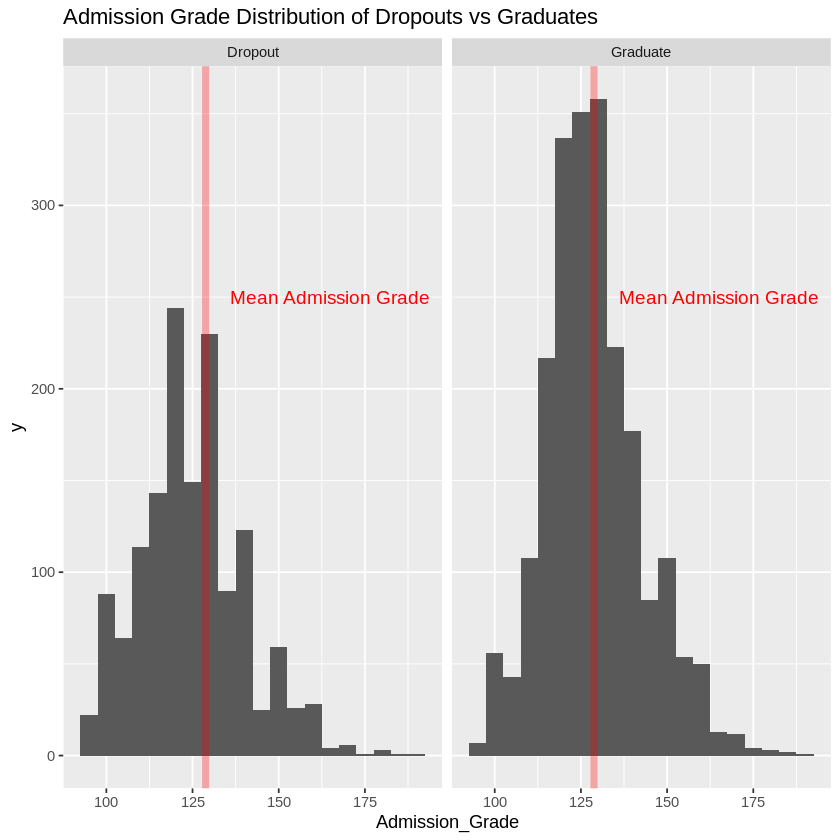

In [32]:
distribution <- dropout_pop %>%
  ggplot(aes(x = Admission_Grade)) +
  geom_histogram(bins=20) +
  ggtitle("Admission Grade Distribution of Dropouts vs Graduates") +
  geom_vline(aes(xintercept = graduates_mean), color = "red", alpha = 0.3, lwd = 2) +
  annotate("text", x = 165, y = 250, label = "Mean Admission Grade", color = "red", size = 4) +
  facet_wrap(~Target, ncol = 2)

distribution

Figure 2. Tidied tibble of IPP student dropout data

From the above graph, we can see that the data is normally distributed.

## 3. Methods: Plan

The credibility of this report hinges on a reliable dataset, as the IPP has previously leveraged this data to construct machine learning classification models for forecasting students' challenges in completing their degrees.
Moreover, the sampling methodology for this data can be seen to be Random, Representative, Generalizable and Unbiased.
 (Is this true? should check)

We plan to conduct a one sided hypothesis test to examine if there is enough evidence to suggest that the admission grades of dropout students are lower than those of students who graduate where. This can be represented in the following hypothesis where $m_1$ is the mean admission grade of students who dropped out and $m_2$ is the mean admission grade of students who graduated.

$H_0: m_1-m_2 = 0$

$H_1: m_1-m_2 < 0$



Furthermore, we can use a confidence interval to capture the true mean admission grades of these students. 
    
One outcome that we may find is that students who dropped out have lower admission grades compared to students who did not drop out. This finding may indicate the students entering higher education with weaker academic backgrounds are more likely to experience attrition. This research can serve as a stepping stone for further investigations into how to strengthen the academic knowledge of these vulnerable students.


## 4. References

Realinho,Valentim, Vieira Martins,Mónica, Machado,Jorge, and Baptista,Luís. (2021). Predict students' dropout and academic success. UCI Machine Learning Repository. https://doi.org/10.24432/C5MC89.